## Final Project Submission

Please fill out:
* Student name: Jessica Forrest-Baldini
* Student pace: Part-time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Import Packages & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from datetime import datetime as date
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('kc_house_data.csv') 
df = pd.DataFrame(data)

## Clean Data

In [2]:
# Drop waterfront - only 146 homes with waterfronts
# Drop view - this represent if the property has been viewed
# Drop id

to_drop = ['waterfront','view','id']
df = df.drop(to_drop, axis=1)

In [3]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [4]:
# Since not all homes have been renovated, I'm going to replace the 'NaN' values for 
# 'yr_renovated' with '0'
df.yr_renovated = df.yr_renovated.fillna(0)
# Add 1 for log transformation later
df.yr_renovated = df.yr_renovated + 1

In [5]:
# Replace NaN basement values with 0 as there are only 454 of them 
# Test median values for these later to see if it improves model

df.sqft_basement = df.sqft_basement.replace('?','0.0').astype(float)
#df.sqft_basement = df.sqft_basement+1

In [6]:
# Take abs of longitude for normalization later on
df.long = abs(df.long)

In [7]:
df.describe().round()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0
mean,540297.0,3.0,2.0,2080.0,15099.0,1.0,3.0,8.0,1789.0,286.0,1971.0,70.0,98078.0,48.0,122.0,1987.0,12758.0
std,367368.0,1.0,1.0,918.0,41413.0,1.0,1.0,1.0,828.0,440.0,29.0,364.0,54.0,0.0,0.0,685.0,27274.0
min,78000.0,1.0,0.0,370.0,520.0,1.0,1.0,3.0,370.0,0.0,1900.0,1.0,98001.0,47.0,121.0,399.0,651.0
25%,322000.0,3.0,2.0,1430.0,5040.0,1.0,3.0,7.0,1190.0,0.0,1951.0,1.0,98033.0,47.0,122.0,1490.0,5100.0
50%,450000.0,3.0,2.0,1910.0,7618.0,2.0,3.0,7.0,1560.0,0.0,1975.0,1.0,98065.0,48.0,122.0,1840.0,7620.0
75%,645000.0,4.0,2.0,2550.0,10685.0,2.0,4.0,8.0,2210.0,550.0,1997.0,1.0,98118.0,48.0,122.0,2360.0,10083.0
max,7700000.0,33.0,8.0,13540.0,1651359.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2016.0,98199.0,48.0,123.0,6210.0,871200.0


We can see here that bedrooms has what seems to be a major outlier, 33 bedrooms. Let's take a deeper look. 

In [8]:
# Compare with other homes in data set that have high number of bedrooms
df[df.bedrooms > 9] 

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8748,8/21/2014,520000.0,11,3.00,3000,4960,2.0,3,7,2400,600.0,1918,2000.0,98106,47.5560,122.363,1420,4960
13301,8/14/2014,1150000.0,10,5.25,4590,10920,1.0,3,9,2500,2090.0,2008,1.0,98004,47.5861,122.113,2730,10400
15147,10/29/2014,650000.0,10,2.00,3610,11914,2.0,4,7,3010,600.0,1958,1.0,98006,47.5705,122.175,2040,11914
15856,6/25/2014,640000.0,33,1.75,1620,6000,1.0,5,7,1040,580.0,1947,1.0,98103,47.6878,122.331,1330,4700
19239,12/29/2014,660000.0,10,3.00,2920,3745,2.0,4,7,1860,1060.0,1913,1.0,98105,47.6635,122.320,1810,3745


In [9]:
# 33 bedrooms and only 1.75 bathrooms doesn't seem right. It is a pretty big lot at 6,000sqft
# but 33 bedrooms doesn't seem right. Remove. 

to_drop = df[df.bedrooms == 33].index
df = df.drop(to_drop)

In [10]:
df.describe().round()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0
mean,540292.0,3.0,2.0,2080.0,15100.0,1.0,3.0,8.0,1789.0,286.0,1971.0,70.0,98078.0,48.0,122.0,1987.0,12759.0
std,367376.0,1.0,1.0,918.0,41414.0,1.0,1.0,1.0,828.0,440.0,29.0,364.0,54.0,0.0,0.0,685.0,27275.0
min,78000.0,1.0,0.0,370.0,520.0,1.0,1.0,3.0,370.0,0.0,1900.0,1.0,98001.0,47.0,121.0,399.0,651.0
25%,322000.0,3.0,2.0,1430.0,5040.0,1.0,3.0,7.0,1190.0,0.0,1951.0,1.0,98033.0,47.0,122.0,1490.0,5100.0
50%,450000.0,3.0,2.0,1910.0,7619.0,2.0,3.0,7.0,1560.0,0.0,1975.0,1.0,98065.0,48.0,122.0,1840.0,7620.0
75%,645000.0,4.0,2.0,2550.0,10686.0,2.0,4.0,8.0,2210.0,550.0,1997.0,1.0,98118.0,48.0,122.0,2360.0,10083.0
max,7700000.0,11.0,8.0,13540.0,1651359.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2016.0,98199.0,48.0,123.0,6210.0,871200.0


We can see price has some big outliers as well, as the 75th percentile is \\$ 645,000 and the max is \\$ 7,700,000, which is \\$ 7M more. 

We can see that sqft_lot also has some big outliers with the 75th percentile being just 10,686 sq. ft. while the max is 1,651,359 sq. ft.

Bedrooms appears to have an outlier at 33, with the 75th percentile being just 4.

Let's take a closer look at the percentiles for each.

In [11]:
# for i in range(0,100):
#     q = i/100
#     print("{} percentile: {}".format(q, df.price.quantile(q=q)))

I'm going to remove the bottom and top percentile to remove outliers.

In [12]:
orig_tot = len(df)
df = df[(df.price >= 154000.0) & (df.price <= 1970000.0)] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.019864789775884423


In [13]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,1.0,98178,47.5112,122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,1992.0,98125,47.7210,122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,1933,1.0,98028,47.7379,122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,1.0,98136,47.5208,122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,1.0,98074,47.6168,122.045,1800,7503


In [14]:
# for i in range(0,100):
#     q = i/100
#     print("{} percentile: {}".format(q, df.sqft_lot.quantile(q=q)))

In [15]:
orig_tot = len(df)
df = df[(df.sqft_lot >= 1010.61) & (df.sqft_lot <= 213008.0)] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.019842207209335286


In [16]:
# for i in range(0,100):
#     q = i/100
#     print("{} percentile: {}".format(q, df.bedrooms.quantile(q=q)))

In [17]:
# orig_tot = len(df)
# df = df[(df.bedrooms >= 2.0) & (df.bedrooms <= 6.0)] # Subsetting to remove extreme outliers
# print('Percent removed:', (orig_tot -len(df))/orig_tot)

### 'sqft_basement'

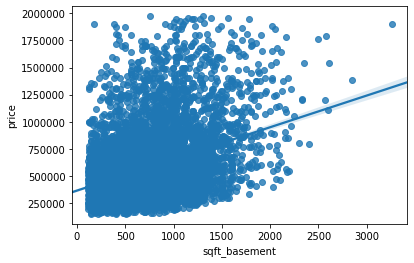

In [18]:
sns.regplot(df[df.sqft_basement >= 110].sqft_basement,df[df.sqft_basement >= 110].price);

Only 8,317 of the 32,000+ homes have basements, so we're going to bin them. I used zero as one bin and then did a quartile split for all the 'sqft_basement' values for homes with basements. 

In [19]:
# # Bin 'sqft_basement' starting at the min square footage for homes with a basement
# bins = pd.qcut(df.sqft_basement[df.sqft_basement >= 110],q=4)
# bins.value_counts()

In [20]:
# Bin sqft_basement

bins_sqft_basement = [0,109,450,980,5000]

# Bin data & return dummies
def binned_dummies(data, features, bins):
    data_bins = pd.cut(data, bins)
    data_bins = data_bins.cat.as_unordered()
    dummies = pd.get_dummies(data_bins, prefix = features, drop_first=True)
    return dummies

dummies_sqft_basement = binned_dummies(df.sqft_basement,'sqft_basement', bins_sqft_basement)

# Remove original column from data set
df = df.drop(['sqft_basement'], axis=1)
                                            
# Add new columns in
df = pd.concat([df, dummies_sqft_basement], axis=1)

In [21]:
# plt.hist(df.grade);

In [22]:
# plt.hist(df.condition);

In [23]:
# df.condition.describe()

In [24]:
# plt.hist(df.long);

In [25]:
# Define function to convert datestr to datenum
def datenum(datestr):
    '''
    Convert datestring in the format MM/DD/YYYY
    to MATLAB style datenum
    '''
    datenum = date.toordinal(date((int(datestr.split('/', -1)[2])),
                                  (int(datestr.split('/', -1)[0])),
                                  (int(datestr.split('/', -1)[1]))
                                 ))+366
    return datenum

# Apply to date column
df.date = df.date.map(datenum)

Explore the data and check for any outliers.

In [26]:
# round(df.describe(),1)

'sqft_lot' seems to have a major outlier at 1,651,359 sqft. Let's take a closer look.

In [27]:
# print(df.sqft_lot.median())
# display(df.sort_values(by='sqft_lot', ascending=False).head(5))

This appears to be the highest, but not necessarily an outlier. Let's go ahead and leave it for now. 

In [28]:
# df.long.describe()

In [29]:
# plt.hist(df.long);

## Normalize, MinMax Scale, Standardize, 
One-Hot Encode

First, check for normality, heteroscedasticity & discover categorical data. Can get a good idea of categorical features from looking at the data above, but let's explore normality, categorical and any relationships using a pairplot.

In [30]:
# Commented out because takes a long time to run
#sns.pairplot(df)

While 'condition' and 'grade' are technically categorical, they are on a scale, so I am going to leave them as is, and will min-max scale them. 

In [31]:
# Normalize Data

# Log Transform 

# Continuous variables
features = ['date','price','sqft_living','lat','long','bedrooms',
            'bathrooms','floors','condition','grade','sqft_lot',
            'sqft_above','yr_built','yr_renovated','sqft_living15',
            'sqft_lot15','zipcode']

df_cont_features = df[features]

# Add '_log' to continuous variable column names
log_names = [f'{column}_log' for column in df_cont_features.columns]

# Log transform continuous variables
df_log = np.log(df_cont_features)
df_log.columns = log_names


### Normalize (subract mean and divide by std)

# Define function to normalize
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# Apply function to normalize
df_log_norm = df_log.apply(normalize)

# Define function to min-max scale
def minmaxscale(feature):
    return (feature-min(feature))/(max(feature)-min(feature))

# Apply function to min-max scale
df_log_norm_scale = df_log.apply(minmaxscale)

# Remove original column from data set
df = df.drop(features, axis=1)

# Add new columns in
df = pd.concat([df, df_log_norm_scale], axis=1) 

In [32]:
# df.head()

## Check for Multicollinearity 

### Multicollinearity

In [33]:
# Take a look at the correlation matrix to check for multicollinearity
abs(df.corr()) > 0.75

,"sqft_basement_(109, 450]","sqft_basement_(450, 980]","sqft_basement_(980, 5000]",date_log,price_log,sqft_living_log,lat_log,long_log,bedrooms_log,bathrooms_log,floors_log,condition_log,grade_log,sqft_lot_log,sqft_above_log,yr_built_log,yr_renovated_log,sqft_living15_log,sqft_lot15_log,zipcode_log
"sqft_basement_(109, 450]",True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(450, 980]",False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(980, 5000]",False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
date_log,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price_log,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living_log,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
lat_log,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
long_log,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms_log,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
bathrooms_log,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [34]:
# # Check & see if sqft_lot15 & sqft_living15 are correlated with sqft_lot & sqft_living
# sns.regplot(df.sqft_lot,df.sqft_lot15)
# plt.show()
# sns.regplot(df.sqft_living,df.sqft_living15)
# plt.show()

We can see that 'sqft_lot15' & 'sqft_living15' are correlated with 'sqft_lot' & 'sqft_living', which makes sense because the features appended with 15 represent the average of the 15 nearest neighbors. 

We will remove these values to prevent multicollinearity in our model. 

In [35]:
# # Remove sqft_lot15 & sqft_living15
# df = df.drop(['sqft_lot15','sqft_living15'], axis=1)

In [36]:
# # Take a look at the correlation matrix to check for multicollinearity
# df.corr() > 0.75

We can see here that 'sqft_living' seems to be highly correlated with multiple features such as 'bathrooms', 'grade', and 'sqft_above'. 'sqft_living' represents the square footage of the entire home and seems that it would be a strong indicator of home price. The squarefoot of other features are essentially subsets of the overall home squarefootage. So for now I am going to remove it. However, it could be kept in place and other features removed later on to see if this improves the overall performance of the model.

In [37]:
# # Remove 'sqft_living' to prevent multicollinearity 
# # as it is highly correlated with multiple features

# df = df.drop(['sqft_living'], axis=1)

In [38]:
# abs(df.corr()) > 0.75

It looks like 'sqft_above' and 'grade' are highly correlated, so we should only keep one to prevent multicollinearity. 

For now I'm going to keep 'sqft_above', but can also test removing 'sqft_above' and one-hot-encoding 'grade' later on to see if it improves performance of the model. 

In [39]:
# # We can see the relationship here between 'sqft_above' and 'grade', it appears to possibly
# # be polynomial. While grade is categorical, it is continuous
# sns.regplot(df.grade,df.sqft_above);

Since the relationship looks slightly polynomial, and 'grade' technically is categorical, I want to look at their distributions to further explore the relationship. Let's look at the histograms/distplot.

In [40]:
# sns.distplot(df.sqft_above)
# plt.show()
# plt.hist(df.grade)
# plt.show()

Both do appear to be skewed in the same direction, so perhaps they are linearly related. Okay, I will remove grade. 

In [41]:
# df = df.drop(['grade'], axis=1)

In [42]:
# df.head()

## Start Modeling

### Split train/test datasets

In [43]:
# Separate target and feature variables

X = df.drop(['price_log'],axis=1)
y = df.price_log

In [44]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split data with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Fit Model

In [45]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model class
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

# Calculate predictions on test set
y_hat_test = linreg.predict(X_test)

### Cross Validate Model

In [46]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

# Test Errors Results
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

RMSE: 0.0977927212573198


In [47]:
from sklearn.model_selection import KFold

crossval = KFold(n_splits=3, shuffle=True, random_state=1)

baseline_R2 = np.mean(cross_val_score(linreg, X, y, scoring='r2', cv=crossval))
baseline_R2

0.7377436525261803

### Statsmodel (OLS)

In [48]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     3083.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        18:57:51   Log-Likelihood:                 18903.
No. Observations:               20747   AIC:                        -3.777e+04
Df Residuals:                   20727   BIC:                        -3.761e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.6067      0.011    -56.478      0.000      -0.628      -0.586
sqft_basement_(109, 450]      0.0313      0.003     10.419      0.000       0.025       0.037
sqft_basement_(450, 980]      0.0298      0.004      7.551      0.000       0.022       0.038
sqft_basement_(980, 5000]     0.0551      0.005     10.152      0.000       0.044       0.066
date_log                      0.0290      0.002     12.364      0.000       0.024       0.034
sqft_living_log               0.2041      0.028      7.260      0.000       0.149       0.259
lat_log                       0.3226      0.003     97.859      0.000       0.316       0.329
long_log                      0.0450      0.008      5.658      0.000       0.029       0.061
bedrooms_log                 -0.1246      0.008    -15.845      0.000      -0.140      -0.109
bathrooms_log                 0.0884      0.009     10.241      0.000       0.071       0.105
floors_log                    0.0452      0.004     11.744      0.000       0.038       0.053
condition_log                 0.1283      0.007     19.028      0.000       0.115       0.142
grade_log                     0.7013      0.012     58.523      0.000       0.678       0.725
sqft_lot_log                  0.0076      0.011      0.666      0.505      -0.015       0.030
sqft_above_log                0.2170      0.026      8.373      0.000       0.166       0.268
yr_built_log                 -0.1815      0.004    -43.957      0.000      -0.190      -0.173
yr_renovated_log              0.0346      0.004      8.768      0.000       0.027       0.042
sqft_living15_log             0.2864      0.009     30.612      0.000       0.268       0.305
sqft_lot15_log               -0.0792      0.015     -5.412      0.000      -0.108      -0.051
zipcode_log                  -0.0333      0.003    -10.329      0.000      -0.040      -0.027
==============================================================================
Omnibus:                      508.112   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              841.461
Skew:                           0.228   Prob(JB):                    1.90e-183
Kurtosis:                       3.875   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interactions

In [49]:
from itertools import combinations

# Find top interactions by R^2 value

# Use combinations from itertools to create all possible combinations of two features
feat_combinations = combinations(X_train.columns, 2)

# Empty list to fill for interactons values
interactions = []

# for i, (feature1,feature2) in feature_combinations:
for i, (a, b) in enumerate(feat_combinations):
    # fill interatctions list with feature a * feature b
    X_train['interaction'] = X_train[a] * X_train[b]
    R2 = np.mean(cross_val_score(linreg, X_train, y_train, scoring='r2', cv=crossval))
    if R2 > baseline_R2:
        interactions.append((a, b, round(R2,5)))
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

Top 3 interactions: [('sqft_living_log', 'grade_log', 0.74793), ('bathrooms_log', 'grade_log', 0.74706), ('long_log', 'zipcode_log', 0.74697)]


We can see here that the top 3 interactions are all between sqft_living, grade, and bathrooms. This is affirming as we could see in our EDA that these three each had apparent relationships with price.

Let's go ahead and add these interactions into our model one at a time to see how they affect the R^2 and RMSE values of our model.

# Best Performing Model - So Far

In [50]:
#Build a final model with interactions
#Use 10-fold cross-validation to build a model using the above interaction.

crossval = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['sqft_living_log*grade_log'] = final['sqft_living_log'] * final['grade_log']
final['bathrooms_log*grade_log'] = final['bathrooms_log'] * final['grade_log']
final['sqft_living_log*bathrooms_log'] = final['long_log'] * final['zipcode_log']

final_model_R2 = np.mean(cross_val_score(linreg, final, y, scoring='r2', cv=crossval))

print(final_model_R2)

import statsmodels.api as sm
df_inter_sm = sm.add_constant(final)
model = sm.OLS(y,final)
results = model.fit()

results.summary()

0.7525820481719251


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     2882.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        18:58:00   Log-Likelihood:                 19518.
No. Observations:               20747   AIC:                        -3.899e+04
Df Residuals:                   20724   BIC:                        -3.881e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0354      0.020     -1.815      0.069      -0.074       0.003
sqft_basement_(109, 450]          0.0257      0.003      8.798      0.000       0.020       0.031
sqft_basement_(450, 980]          0.0178      0.004      4.626      0.000       0.010       0.025
sqft_basement_(980, 5000]         0.0270      0.005      5.059      0.000       0.017       0.037
date_log                          0.0288      0.002     12.687      0.000       0.024       0.033
sqft_living_log                  -0.1926      0.055     -3.526      0.000      -0.300      -0.086
lat_log                           0.3173      0.003     98.848      0.000       0.311       0.324
long_log                         -0.1874      0.013    -14.677      0.000      -0.212      -0.162
bedrooms_log                     -0.0879      0.008    -11.389      0.000      -0.103      -0.073
bathrooms_log                    -0.1343      0.052     -2.562      0.010      -0.237      -0.032
floors_log                        0.0382      0.004     10.143      0.000       0.031       0.046
condition_log                     0.1327      0.007     20.215      0.000       0.120       0.146
grade_log                         0.0227      0.028      0.822      0.411      -0.031       0.077
sqft_lot_log                      0.0047      0.011      0.419      0.676      -0.017       0.027
sqft_above_log                    0.1073      0.025      4.218      0.000       0.057       0.157
yr_built_log                     -0.1682      0.004    -41.718      0.000      -0.176      -0.160
yr_renovated_log                  0.0362      0.004      9.444      0.000       0.029       0.044
sqft_living15_log                 0.2794      0.009     30.405      0.000       0.261       0.297
sqft_lot15_log                   -0.1066      0.014     -7.485      0.000      -0.134      -0.079
zipcode_log                      -0.7259      0.030    -24.155      0.000      -0.785      -0.667
sqft_living_log*grade_log         0.8221      0.079     10.426      0.000       0.668       0.977
bathrooms_log*grade_log           0.3855      0.086      4.476      0.000       0.217       0.554
sqft_living_log*bathrooms_log     0.8515      0.037     23.064      0.000       0.779       0.924
==============================================================================
Omnibus:                      489.841   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              915.178
Skew:                           0.177   Prob(JB):                    1.87e-199
Kurtosis:                       3.966   Cond. No.                         486.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance mat

In [51]:
# Test Errors Results
cv_5_results = cross_val_score(linreg, final, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

RMSE: 0.09487025399298141


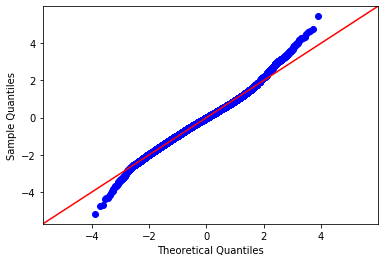

In [52]:
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)

We can see that sqft_lot is no longer significant. Let's go ahead and remove it and see how it affects our model.

In [53]:
final = final.drop(['sqft_lot_log','grade_log'], axis=1)

In [54]:
final.head()

,const,"sqft_basement_(109, 450]","sqft_basement_(450, 980]","sqft_basement_(980, 5000]",date_log,sqft_living_log,lat_log,long_log,bedrooms_log,bathrooms_log,...,condition_log,sqft_above_log,yr_built_log,yr_renovated_log,sqft_living15_log,sqft_lot15_log,zipcode_log,sqft_living_log*grade_log,bathrooms_log*grade_log,sqft_living_log*bathrooms_log
0,1.0,0,0,0,0.420577,0.383390,0.573100,0.787789,0.458157,0.255958,...,0.682606,0.386791,0.485598,0.000000,0.452896,0.332244,0.894035,0.221536,0.147901,0.704311
1,1.0,1,0,0,0.566732,0.640707,0.909499,0.839426,0.458157,0.555410,...,0.682606,0.589968,0.450745,0.998426,0.539649,0.378617,0.626499,0.370222,0.320934,0.525899
2,1.0,0,0,0,0.766714,0.242275,0.936533,0.767793,0.289065,0.255958,...,0.682606,0.244424,0.293018,0.000000,0.717562,0.386904,0.136483,0.114525,0.120993,0.104790
3,1.0,0,1,0,0.566732,0.551134,0.588526,0.901023,0.578130,0.661642,...,1.000000,0.347863,0.572419,0.000000,0.458435,0.313452,0.682037,0.318463,0.382318,0.614531
4,1.0,0,0,0,0.748768,0.500176,0.742607,0.611025,0.458157,0.511916,...,0.682606,0.504613,0.761879,0.000000,0.563223,0.375855,0.368922,0.334566,0.342419,0.225421


In [55]:
final_model_R2 = np.mean(cross_val_score(linreg, final, y, scoring='r2', cv=crossval))

print(final_model_R2)

import statsmodels.api as sm
df_inter_sm = sm.add_constant(final)
model = sm.OLS(y,final)
results = model.fit()

results.summary()

0.7526371727792179


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     3170.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        18:58:01   Log-Likelihood:                 19517.
No. Observations:               20747   AIC:                        -3.899e+04
Df Residuals:                   20726   BIC:                        -3.883e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0238      0.013     -1.768      0.077      -0.050       0.003
sqft_basement_(109, 450]          0.0257      0.003      8.797      0.000       0.020       0.031
sqft_basement_(450, 980]          0.0176      0.004      4.580      0.000       0.010       0.025
sqft_basement_(980, 5000]         0.0265      0.005      4.999      0.000       0.016       0.037
date_log                          0.0288      0.002     12.676      0.000       0.024       0.033
sqft_living_log                  -0.1995      0.054     -3.700      0.000      -0.305      -0.094
lat_log                           0.3174      0.003     99.256      0.000       0.311       0.324
long_log                         -0.1871      0.013    -14.679      0.000      -0.212      -0.162
bedrooms_log                     -0.0876      0.008    -11.363      0.000      -0.103      -0.072
bathrooms_log                    -0.1441      0.051     -2.827      0.005      -0.244      -0.044
floors_log                        0.0378      0.004     10.197      0.000       0.031       0.045
condition_log                     0.1329      0.007     20.310      0.000       0.120       0.146
sqft_above_log                    0.1061      0.025      4.192      0.000       0.056       0.156
yr_built_log                     -0.1678      0.004    -42.414      0.000      -0.176      -0.160
yr_renovated_log                  0.0363      0.004      9.485      0.000       0.029       0.044
sqft_living15_log                 0.2795      0.009     30.441      0.000       0.261       0.297
sqft_lot15_log                   -0.1022      0.007    -13.879      0.000      -0.117      -0.088
zipcode_log                      -0.7260      0.030    -24.163      0.000      -0.785      -0.667
sqft_living_log*grade_log         0.8391      0.076     11.012      0.000       0.690       0.988
bathrooms_log*grade_log           0.4025      0.083      4.824      0.000       0.239       0.566
sqft_living_log*bathrooms_log     0.8514      0.037     23.067      0.000       0.779       0.924
==============================================================================
Omnibus:                      488.115   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              911.192
Skew:                           0.176   Prob(JB):                    1.37e-198
Kurtosis:                       3.964   Cond. No.                         463.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# Test Errors Results
cv_5_results = cross_val_score(linreg, final, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

RMSE: 0.0948558888032349


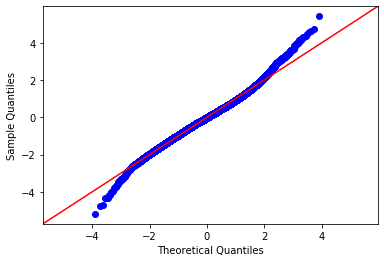

In [57]:
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)